# CSE327 Homework 4
**Due date: 23:59 on Nov. 20, 2018 (Thuesday)**

## Description
---
This project is an introduction to deep learning tools for computer vision. You will design and train deep convolutional networks for scene recognition using [PyTorch](http://pytorch.org). You can visualize the
structure of the network with [mNeuron] (http://vision03.csail.mit.edu/cnn_art/index.html)

Remember Homework 3: Scene recognition with bag of words. You worked hard to design a bag of features representations that achieved 60% to 70% accuracy (most likely) on 15-way scene classification. We're going to attack the same task with deep learning and get higher accuracy. Training from scratch won't work quite as well as homework 3 due to the insufficient amount of data, fine-tuning an existing network will work much better than homework 3.

In Problem 1 of the project you will train a deep convolutional network from scratch to recognize scenes. The starter codes gives you methods to load data and display them. You will need to define a simple network architecture and add jittering, normalization, and regularization to increase recognition accuracy to 50, 60, or perhaps 70%. Unfortunately, we only have 1,500 training examples so it doesn't seem possible to train a network from scratch which outperforms hand-crafted features

For Problem 2 you will instead fine-tune a pre-trained deep network to achieve about 85% accuracy on the task. We will use the pretrained AlexNet network which was not trained to recognize scenes at all. 

These two approaches represent the most common approaches to recognition problems in computer vision today -- train a deep network from scratch if you have enough data (it's not always obvious whether or not you do), and if you cannot then instead fine-tune a pre-trained network.

There are 2 problems in this homework with a total of 100 points. There is no bonus question for this homework. Be sure to read **Submission Guidelines** below. They are important. For the problems requiring text descriptions, you might want to add a markdown block for that.

## Dataset
---
You will be using the same dataset in homework 3. The dataset contains 100 images from each category (i.e. 1500 training examples total and 1500 test cases total).  Download the dataset [here](https://drive.google.com/a/cs.stonybrook.edu/file/d/0B446EB1iI6_Qc0Q1NTRTajdUVTg/view?usp=sharing).

Once downloded, extract it to your root folder Surname_Givenname_SBUID. Under your root folder, there should be a folder named "data" (i.e. XXX/Surname_Givenname_SBUID/data).

## Some Tutorials (PyTorch)
---
- You will be using PyTorch for deep learning toolbox (follow the [link](http://pytorch.org) for installation).
- For PyTorch beginners, please read this [tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) before doing your homework.
- Feel free to study more tutorials at http://pytorch.org/tutorials/.
- Find cool visualization here at http://playground.tensorflow.org.

I am releasing a working setup on my computer for your reference: <br>
- OS: Windows 10 <br>
- Python: 3.5.2 <br>
- Pytorch (Stable + Windows + Conda + Python 3.5 + None): 0.4.1 <br>
OpenCV and Pillow is required.


## Starter Code
---
In the starter code, you are provided with a function that loads data into minibatches for training and testing in PyTorch.

In [1]:
# import packages here
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random 

import torch
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy.core.numeric as _nx
import torchvision.models as models
import time
from sklearn import svm

In [4]:
# ==========================================
#    Load Training Data and Testing Data
# ==========================================

class_names = [name[11:] for name in glob.glob('data/train/*')]
class_names = dict(zip(range(len(class_names)), class_names))
print(class_names)

def img_norm(img):
    return 2 * (np.float32(img) / 255 - 0.5) 


def img_mirror(img, axis=None):
    if not hasattr(img, 'ndim'):
        img = asarray(img)
    if axis is None:
        indexer = (np.s_[::-1],) * img.ndim
    else:
        axis = _nx.normalize_axis_tuple(axis, img.ndim)
        indexer = [np.s_[:]] * img.ndim
        for ax in axis:
            indexer[ax] = np.s_[::-1]
        indexer = tuple(indexer)
    return img[indexer]
  
def img_rotate(img, angle):
  (rows, cols) = img.shape[:2]
  M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1) 
  res = cv2.warpAffine(img, M, (cols, rows)) 
  return res

def load_dataset(path, img_size, num_per_class=-1, batch_num=1, shuffle=False, augment=False, is_color=False, rotate=False):
    
    data = []
    labels = []
    
    if is_color:
        channel_num = 3
    else:
        channel_num = 1
        
    # read images and resizing
    for id, class_name in class_names.items():
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            if is_color:
                img = cv2.imread(filename)
            else:
                img = cv2.imread(filename, 0)
            
            # resize the image
            img = cv2.resize(img, img_size, cv2.INTER_LINEAR)
            
            if is_color:
                img = np.transpose(img, [2, 0, 1])
            
            # norm pixel values to [-1, 1]
            data.append(img_norm(img))

    # augment data
    if augment:
        #aug_data = [np.flip(img, 1) for img in data]
        aug_data = [img_mirror(img,1) for img in data]
        data.extend(aug_data)
        labels.extend(labels)
        
        # norm data to zero-centered
        #mean_img = np.mean(np.array(data), 0)
        #data = data - mean_img
        #data = [data[i] for i in xrange(data.shape[0])]
    if rotate:    
        aug_data = [img_rotate(img,30) for img in data]
        data.extend(aug_data)
        labels.extend(labels)
        

    # randomly permute (this step is important for training)
    if shuffle:
        bundle = list(zip(data, labels))
        random.shuffle(bundle)
        data, labels = zip(*bundle)
    
    # divide data into minibatches of TorchTensors
    if batch_num > 1:
        batch_data = []
        batch_labels = []
        
        print(len(data))
        print(batch_num)
        
        for i in range(int(len(data) / batch_num)):
            minibatch_d = data[i*batch_num: (i+1)*batch_num]
            minibatch_d = np.reshape(minibatch_d, (batch_num, channel_num, img_size[0], img_size[1]))
            batch_data.append(torch.from_numpy(minibatch_d))

            minibatch_l = labels[i*batch_num: (i+1)*batch_num]
            batch_labels.append(torch.LongTensor(minibatch_l))
        data, labels = batch_data, batch_labels 
    
    return zip(batch_data, batch_labels)

{0: 'Mountain', 1: 'Forest', 2: 'Bedroom', 3: 'OpenCountry', 4: 'LivingRoom', 5: 'Coast', 6: 'Office', 7: 'InsideCity', 8: 'Kitchen', 9: 'Industrial', 10: 'TallBuilding', 11: 'Highway', 12: 'Street', 13: 'Suburb', 14: 'Store'}


In [5]:
# load data into size (64, 64)
img_size = (64, 64)
batch_num = 50 # training sample number per batch 

# load training dataset
trainloader_small = list(load_dataset('data/train/', img_size, batch_num=batch_num, shuffle=True, augment=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

# load testing dataset
testloader_small = list(load_dataset('data/test/', img_size, num_per_class=100, batch_num=batch_num))
test_num = len(testloader_small)
print("Finish loading %d minibatches(=%d) of testing samples." % (test_num, batch_num))



# load dataset with rotated images augmented
trainloader_small_rot = list(load_dataset('data/train/', img_size, batch_num=batch_num, shuffle=True, augment=True, rotate=True))
testloader_small_rot = list(load_dataset('data/test/', img_size, num_per_class=100, batch_num=batch_num))
print len(trainloader_small_rot), len(testloader_small_rot)

3000
50
Finish loading 60 minibatches(=50) of training samples.
1500
50
Finish loading 30 minibatches(=50) of testing samples.
6000
50
1500
50
120 30


Suburb


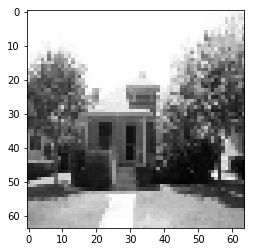

OpenCountry


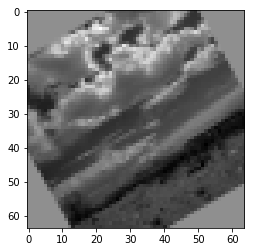

In [6]:
# show some images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if len(npimg.shape) > 2:
        npimg = np.transpose(img, [1, 2, 0])
    plt.figure
    plt.imshow(npimg, 'gray')
    plt.show()
img, label = trainloader_small[0][0][11][0], trainloader_small[0][1][11]
label = int(np.array(label))
print(class_names[label])
imshow(img)

# rotated images included
img, label = trainloader_small_rot[0][0][11][0], trainloader_small_rot[0][1][11]
label = int(np.array(label))
print(class_names[label])
imshow(img)

## Problem 1: Training a Network From Scratch
{Part 1: 35 points} Gone are the days of hand designed features. Now we have end-to-end learning in which a highly non-linear representation is learned for our data to maximize our objective (in this case, 15-way classification accuracy). Instead of 70% accuracy we can now recognize scenes with... 25% accuracy. OK, that didn't work at all. Try to boost the accuracy by doing the following:

**Data Augmentation**: We don't have enough training data, let's augment the training data.
If you left-right flip (mirror) an image of a scene, it never changes categories. A kitchen doesn't become a forest when mirrored. This isn't true in all domains — a "d" becomes a "b" when mirrored, so you can't "jitter" digit recognition training data in the same way. But we can synthetically increase our amount of training data by left-right mirroring training images during the learning process.

After you implement mirroring, you should notice that your training error doesn't drop as quickly. That's actually a good thing, because it means the network isn't overfitting to the 1,500 original training images as much (because it sees 3,000 training images now, although they're not as good as 3,000 truly independent samples). Because the training and test errors fall more slowly, you may need more training epochs or you may try modifying the learning rate. You should see a roughly 10% increase in accuracy by adding mirroring. You are **required** to implement mirroring as data augmentation for this part.

You can try more elaborate forms of jittering -- zooming in a random amount, rotating a random amount, taking a random crop, etc. These are not required, you might want to try these in the bonus part.

**Data Normalization**: The images aren't zero-centered. One simple trick which can help a lot is to subtract the mean from every image. It would arguably be more proper to only compute the mean from the training images (since the test/validation images should be strictly held out) but it won't make much of a difference. After doing this you should see another 15% or so increase in accuracy. This part is **required**.

**Network Regularization**: Add dropout layer. If you train your network (especially for more than the default 30 epochs) you'll see that the training error can decrease to zero while the val top1 error hovers at 40% to 50%. The network has learned weights which can perfectly recognize the training data, but those weights don't generalize to held out test data. The best regularization would be more training data but we don't have that. Instead we will use dropout regularization.

What does dropout regularization do? It randomly turns off network connections at training time to fight overfitting. This prevents a unit in one layer from relying too strongly on a single unit in the previous layer. Dropout regularization can be interpreted as simultaneously training many "thinned" versions of your network. At test, all connections are restored which is analogous to taking an average prediction over all of the "thinned" networks. You can see a more complete discussion of dropout regularization in this [paper](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf).

The dropout layer has only one free parameter — the dropout rate — the proportion of connections that are randomly deleted. The default of 0.5 should be fine. Insert a dropout layer between your convolutional layers. In particular, insert it directly before your last convolutional layer. Your test accuracy should increase by another 10%. Your train accuracy should decrease much more slowly. That's to be expected — you're making life much harder for the training algorithm by cutting out connections randomly. 

If you increase the number of training epochs (and maybe decrease the learning rate) you should be able to achieve around 50% test accuracy. In this part, you are **required** to add dropout layer to your network.

Please give detailed descriptions of your network layout in the following format:<br><hr>
**Data augmentation** : Implemented function img_mirror(img, axis) that mirrors the image along the axis mentioned as parameter. It is the same as what np.flip() does internally. implemented img_rotate(img, angle) to generate rotated images. Tried experiments on 2 imagesets - <br>
<b><i> 
   Model1 =  1500 train + 1500 mirrored + 3000 rotated = 6000 train images<br>
    Model2 = 1500 train  + 1500 mirrored = 3000 train images<br>
 </b></i> <br>
**Data normalization** : Tried the model on zero-centered images. However, didnot see any improvement, so didnot encorporate it. <br>
**Model** : Dropout layer present.

| Layer(type) | Output_Shape | Param# |
| ----------- | ------------ | ------ |
| Conv2d-1 | [-1,16,30,30] | 416 |
| BatchNorm2d-2 | [-1,16,30,30] | 32 |
| ReLU-3 | [-1,16,30,30] | 0 |
| MaxPool2d-4 | [-1,16,15,15] | 0 |
| Conv2d-5 | [-1,8,13,13] | 1,160 |
| BatchNorm2d-6 | [-1,8,13,13] | 16 |
| ReLU-7 | [-1,8,13,13] | 0 |
| MaxPool2d-8 | [-1,8,6,6] | 0 |
| <b>Dropout-9</b> | [-1,288] | 0 |
| Linear-10 | [-1,15] | 4,335 |

<b>Total params: 5,959<br>
Trainable params: 5,959<br>
Non-trainable params: 0<br>

Input size (MB): 0.02<br>
Forward/backward pass size (MB): 0.39<br>
Params size (MB): 0.02<br>
Estimated Total Size (MB): 0.43<br></b>

<hr>

Then report the final accuracy on test set and time consumed for training and testing separately.

{Part 2: 15 points} Try **three techniques** taught in the class to increase the accuracy of your model. Such as increasing training data by randomly rotating training images, adding batch normalization, different activation functions (e.g., sigmoid) and model architecture modification. Note that too many layers can do you no good due to insufficient training data. Clearly describe your method and accuracy increase/decrease for each of the three techniques.<br>

**1. Increasing training data** : img_mirror and img_rotate functions written. Tried experiments on two sets- <br>
<b><i> 
   Model1 =  1500 train + 1500 mirrored + 3000 rotated = 6000 train images<br>
    Model2 = 1500 train  + 1500 mirrored = 3000 train images<br>
 </b></i> 
However, heuristically, I dont feel rotated images will help. Because consider "TallBuilding", it would learn vertical lines/edges as one of the features in early layers, however in the rotated images, these vertical edge features would be inclined at an angle. 
<br>
**2. BatchNormalization** : improves gradient flow through very deep networks, reduces dependency on careful initialization, allows higher learning rates and also provides regularization and reduces dependency on dropout. **Helped increase the accuracy and BatchNorm layers are used in my best model** as seen in table above.
<br>
**3. Different activation functions** : Tried with sigmoid. But ReLU performed better. because of ReLU we do not face computing exponents as in sigmoid. And ReLU doesnot let gradients to vanish or explode. <br>


## Results 
<b><i>   Model1 =  1500 train + 1500 mirrored + 3000 rotated = 6000 train images </b></i><br>
============== Training Completed in :  263.021  seconds <br>
============== Testing Completed in :  0.695  seconds <br>
877 / 1500 <br>
Accuracy of the network on the test images: **58.47 %** <br>
<hr>

### BEST RESULTS -
<b><i>   Model2 =  1500 train + 1500 mirrored  = 3000 train images </b></i><br>
<span style="color:blue">
============== Training Completed in :  133.085  seconds <br>
============== Testing Completed in :  0.691  seconds <br>
920 / 1500 <br>
Accuracy of the network on the test images: **61.33 %** <br>
 <br></span>




In [0]:
use_gpu = torch.cuda.is_available()

# ==========================================
### Helper function for Training Model
# ==========================================
def train(model, loss_fn, optimizer, dataloader, num_epochs = 1):
    t0 = time.time()
    for epoch in range(num_epochs):
        model.train()
        for t, data in enumerate(dataloader):
            x_data = Variable(data[0])
            y_data = Variable(data[1])
            y_output = model(x_data)
            loss = loss_fn(y_output, y_data)
            #if t%20==0:
            #    print('epoch = %d, t = %d, loss = %.4f' % (epoch + 1, t + 1, loss.data[0]))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print('epoch = %d, loss = %.4f' % (epoch + 1, loss.data[0]))
    t1 = time.time()
    print "============== Training Completed in : ", round(t1-t0,3), " seconds\n"
  
  
# ==========================================
### Helper function for Evaluating Model
# ==========================================
def check_accuracy(model1, testloader_small):
    t0 = time.time()
    correct = 0
    total = 0
    class_correct = list(0. for i in range(15))
    class_total = list(0. for i in range(15))
    actual_labels = []
    predicted_labels = []

    for data in testloader_small:
        x_data, y_data = data
        model1.train(False)
        y_output = model1(Variable(x_data))
        _, predictions = torch.max(y_output.data, 1)
        total += y_data.size(0)
        correct += (predictions == y_data).sum()

        actual_labels.append(y_data)
        predicted_labels.append(predictions)
        c = (predictions == y_data).squeeze()
        for i in range(4):
            label = y_data[i]
            class_correct[label] += c[i]
            class_total[label] += 1

    print correct,'/',total
    print('Accuracy of the network on the test images: %d %%' % (100*correct/float(total)))

    t1 = time.time()
    print "============== Testing Completed in : ", round(t1-t0,3), " seconds"

In [0]:
# ==========================================
#       Define Network Architecture
# ==========================================

class q1_model1(nn.Module):

    def __init__(self):
        super(q1_model1, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=2) # 64x64x1 -> 30x30x16
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU(inplace=True) 
        self.pool1 = nn.MaxPool2d(kernel_size=2 , stride=2) # 30x30x16 -> 15x15x16
        #self.dropout1 = nn.Dropout(p=0.5)
        
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, stride=1) # 15x15x16 -> 13x13x8
        self.bn2 = nn.BatchNorm2d(8)
        self.relu2 = nn.ReLU(inplace=True) 
        self.pool2 = nn.MaxPool2d(kernel_size=2 , stride=2) # 13x13x8 -> 6x6x8
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(6*6*8, 15) 

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.dropout1(x) 
        x = self.fc1(x)
        return x

    def flatten(self, x):
        N, C, H, W = x.size()
        return x.view(N, -1)


In [96]:
# ==========================================
# Model1 = With mirrored + rotated images included
# total train images = 6000 
# loader : trainloader_small_rot, testloader_small_rot
# ==========================================
#         Optimize/Train Network
print "MIRRORED + ROTATED IMAGES INCLUDED IN TRAINING #####################"
print "Train images = 6000"
model1 = q1_model1()
print model1
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters()) 
#            Evaluating Network
train(model1, loss_fn, optimizer, trainloader_small_rot, num_epochs = 45)
check_accuracy(model1, testloader_small_rot)
# ==========================================



# ==========================================
# Model2 = With mirrored images included
# total train images = 3000 
# loader : trainloader_small, testloader_small
# ==========================================
#         Optimize/Train Network
print "\n##########################################################"
print "BETTER RESULTS ON BELOW MODEL"
print "MIRRORED IMAGES INCLUDED IN TRAINING #####################"
print "Train images = 3000"
model2 = q1_model1()
print model2
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters()) 
#            Evaluating Network
train(model2, loss_fn, optimizer, trainloader_small, num_epochs = 45)
check_accuracy(model2, testloader_small)
# ==========================================

MIRRORED + ROTATED IMAGES INCLUDED IN TRAINING #####################
Train images = 6000
q1_model1(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5)
  (fc1): Linear(in_features=288, out_features=15, bias=True)
)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:20: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch = 1, loss = 2.2763
epoch = 2, loss = 1.9086
epoch = 3, loss = 1.8039
epoch = 4, loss = 1.6954
epoch = 5, loss = 1.6791
epoch = 6, loss = 1.4146
epoch = 7, loss = 1.4956
epoch = 8, loss = 1.4776
epoch = 9, loss = 1.4168
epoch = 10, loss = 1.2979
epoch = 11, loss = 1.2409
epoch = 12, loss = 1.2721
epoch = 13, loss = 1.3638
epoch = 14, loss = 1.1959
epoch = 15, loss = 1.1965
epoch = 16, loss = 1.1071
epoch = 17, loss = 1.1747
epoch = 18, loss = 1.1065
epoch = 19, loss = 1.1479
epoch = 20, loss = 1.0746
epoch = 21, loss = 1.0791
epoch = 22, loss = 1.0977
epoch = 23, loss = 1.1021
epoch = 24, loss = 1.1170
epoch = 25, loss = 1.1075
epoch = 26, loss = 1.0908
epoch = 27, loss = 1.0896
epoch = 28, loss = 1.1213
epoch = 29, loss = 1.0146
epoch = 30, loss = 1.0771
epoch = 31, loss = 1.0074
epoch = 32, loss = 1.0392
epoch = 33, loss = 0.8947
epoch = 34, loss = 1.0299
epoch = 35, loss = 1.1325
epoch = 36, loss = 1.0480
epoch = 37, loss = 1.0715
epoch = 38, loss = 1.0368
epoch = 39, loss = 1.

## Problem 2: Fine Tuning a Pre-Trained Deep Network
{Part 1: 30 points} Our convolutional network to this point isn't "deep". Fortunately, the representations learned by deep convolutional networks is that they generalize surprisingly well to other recognition tasks. 

But how do we use an existing deep network for a new recognition task? Take for instance,  [AlexNet](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks) network has 1000 units in the final layer corresponding to 1000 ImageNet categories.

**Strategy A**: One could use those 1000 activations as a feature in place of a hand crafted feature such as a bag-of-features representation. You would train a classifier (typically a linear SVM) in that 1000 dimensional feature space. However, those activations are clearly very object specific and may not generalize well to new recognition tasks. It is generally better to use the activations in slightly earlier layers of the network, e.g. the 4096 activations in the last 2nd fully-connected layer. You can often get away with sub-sampling those 4096 activations considerably, e.g. taking only the first 200 activations. 

**Strategy B**: *Fine-tune* an existing network. In this scenario you take an existing network, replace the final layer (or more) with random weights, and train the entire network again with images and ground truth labels for your recognition task. You are effectively treating the pre-trained deep network as a better initialization than the random weights used when training from scratch. When you don't have enough training data to train a complex network from scratch (e.g. with the 15 scene database) this is an attractive option. Fine-tuning can work far better than Strategy A of taking the activations directly from an pre-trained CNN. For example, in [this paper](http://www.cc.gatech.edu/~hays/papers/deep_geo.pdf) from CVPR 2015, there wasn't enough data to train a deep network from scratch, but fine tuning led to 4 times higher accuracy than using off-the-shelf networks directly.

You are required to implement **Strategy B** to fine-tune a pre-trained **AlexNet** for this scene classification task. You should be able to achieve performance of 85% approximately. It takes roughly 35~40 minutes to train 20 epoches with AlexNet.

Please provide detailed descriptions of:<br>
(1) which layers of AlexNet have been replaced<br>
(2) the architecture of the new layers added including activation methods (same as problem 1)<br>
(3) the final accuracy on test set along with time consumption for both training and testing <br>
**DO NOT** turn in the downloaded AlexNet, I will download it myself to test your network.

{Part 2: 20 points} Implement Strategy A where you use the activations of the pre-trained network as features to train one-vs-all SVMs for your scene classification task. Report the final accuracy on test set along with time consumption for both training and testing.

**Hints**:
- Many pre-trained models are available in PyTorch at [here](http://pytorch.org/docs/master/torchvision/models.html).
- For fine-tuning pretrained network using PyTorch, please read this [tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

In [7]:
# reload data with a larger size
img_size = (224, 224)
batch_num = 50 # training sample number per batch 

# load training dataset
trainloader_large = list(load_dataset('data/train/', img_size, batch_num=batch_num, shuffle=True, augment=False, is_color=True))
train_num = len(trainloader_large)
print("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

# load testing dataset
testloader_large = list(load_dataset('data/test/', img_size, num_per_class=100, batch_num=batch_num, is_color=True))
test_num = len(testloader_large)
print("Finish loading %d minibatches(=%d) of testing samples." % (test_num, batch_num))

1500
50
Finish loading 30 minibatches(=50) of training samples.
1500
50
Finish loading 30 minibatches(=50) of testing samples.


### Strategy A 

### Results
<span style="color:blue">
================ Feature Extraction Time :  134.196  seconds <br>
================ Training Time :  0.572  seconds <br>
================ Testing Time :  0.22  seconds <br>
    The accuracy of Strategy A is <b> 79.40 % </b> <br>
</span>


In [100]:
# ==========================================
#       Strategy A = 200 features
# ==========================================
# STRATEGY A
t_start = time.time()
new_model = models.alexnet(pretrained=True)
new_classifier = nn.Sequential(*list(new_model.classifier.children())[:2])
new_model.classifier = new_classifier
print new_model

# get 200 train-features from AlexNet's 4096 dim 2nd last layer 
train_groundtruth_svm = []
train_features = []
i=0
for data in trainloader_large:
    if i%10==0:
      print "train batch : ", str(i)
    i+=1
    x_data, y_data = data
    outputs = new_model(Variable(x_data))
    train_groundtruth_svm.extend(y_data)
    for feat in outputs:
        train_features.append(feat[:200].data.numpy().tolist())

        
# get 200 test-features from AlexNet's 4096 dim 2nd last layer 
test_groundtruth_svm = []
test_features = []
i=0
for data in testloader_large:
    if i%10==0:
      print "test batch : ", str(i)
    i+=1
    x_data, y_data = data
    outputs = new_model(Variable(x_data))
    test_groundtruth_svm.extend(y_data)
    for feat in outputs:
        test_features.append(feat[:200].data.numpy().tolist())

# features from lists to arrays
train_groundtruth_svm = [x.item() for x in train_groundtruth_svm]
test_groundtruth_svm = [x.item() for x in test_groundtruth_svm]

test_features = np.array(test_features)
train_features = np.array(train_features)
test_groundtruth_svm = np.array(test_groundtruth_svm)
train_groundtruth_svm = np.array(train_groundtruth_svm)
t_end = time.time()

print "Feature Extraction Time : " , round(t_end-t_start,3), " seconds ================"
# SVM training part
classifier_svm = svm.LinearSVC(C=0.00099)
t0 = time.time()
classifier_svm.fit(train_features, train_groundtruth_svm) 
t1 = time.time()
print "Training Time : " , round(t1-t0,3), " seconds ================"

# test accuracy
test_predictions_svm = classifier_svm.predict(test_features)
acc = 1.0*sum(test_groundtruth_svm == test_predictions_svm)/len(test_groundtruth_svm)
print ("The accuracy of Strategy A is {:.2f}%".format(acc*100))



AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
  )
)
train batch :  0
train batch :  10
train batch :  20
test batch :  0
test batch :  10


### Strategy B - 

### Layers - 
In the classifier of Alexnet, we have 4 Linear layers at the end. <br>
9216 -> 4096 -> 4096 -> 1000 <br>
This was changed to the following <br>
<b> 9216 -> 4096 -> 256 -> 15 </b> with dropouts and ReLU layers unaltered. The following is the full model architecture.

### Model Architecture
| Layer (type) | Output Shape | Param # |
| ------------ | ------------ | --------|
|     Conv2d-1 | [-1, 64, 55, 55] | 23,296 |
|       ReLU-2 | [-1, 64, 55, 55] | 0 |
|  MaxPool2d-3 | [-1, 64, 27, 27] | 0 |
|     Conv2d-4 | [-1, 192, 27, 27] | 307,392 |
|       ReLU-5 | [-1, 192, 27, 27] | 0 |
|  MaxPool2d-6 | [-1, 192, 13, 13] | 0 |
|     Conv2d-7 | [-1, 384, 13, 13] | 663,936 |
|       ReLU-8 | [-1, 384, 13, 13] | 0 |
|     Conv2d-9 | [-1, 256, 13, 13] | 884,992 |
|      ReLU-10 | [-1, 256, 13, 13] | 0 |
|    Conv2d-11 | [-1, 256, 13, 13] | 590,080 |
|      ReLU-12 | [-1, 256, 13, 13] | 0 |
| MaxPool2d-13 | [-1, 256, 6, 6] | 0 |
|   <b>Dropout-14 | [-1, 9216] | 0 |
|    <b>Linear-15 | [-1, 4096] | 37,752,832 |
|      <b>ReLU-16 | [-1, 4096] | 0 |
|    <b>Linear-17 | [-1, 256] | 1,048,832 |
|      <b>ReLU-18 | [-1, 256] | 0 |
|    <b>Linear-19 | [-1, 15] | 3,855 |

<br>
<b> Total params: 41,275,215 <br>
Trainable params: 41,275,215 <br>
Non-trainable params: 0 <br></b>

Input size (MB): 0.57 <br> 
Forward/backward pass size (MB): 8.21 <br>
Params size (MB): 157.45 <br>
Estimated Total Size (MB): 166.24 <br>


### Results - Strategy B
<span style="color:blue">
================ Training Time :  661.486  seconds <br>
================ Testing Time :  67.19  seconds <br>
1258 / 1500
    The accuracy of Strategy B is <b> 83.87 % </b> <br>
  </span>

In [105]:
# ==========================================
#       Strategy B
# ==========================================
# STRATEGY B

#new_model_b = models.alexnet(pretrained=True)
#alexnet_clr = list(new_model_b.classifier.children())
#new_clr = alexnet_clr[1:4]+[nn.Linear(4096,1024)]+[alexnet_clr[5]]+[nn.Linear(1024,15)]
#new_clr = alexnet_clr[0:3]+[nn.Linear(4096,15)]
#new_classifier = nn.Sequential(*(new_clr))
#new_model_b.classifier = new_classifier


#new_model_b = models.alexnet(pretrained=True)
#alexnet_clr = list(new_model_b.classifier.children())
#alexnet_ft = list(new_model_b.features.children())
#new_ft = alexnet_ft[0:6]+[nn.Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))]+alexnet_ft[11:]
#new_clr = alexnet_clr[1:4]+[nn.Linear(4096,1024)]+[alexnet_clr[5]]+[nn.Linear(1024,15)]
#new_classifier = nn.Sequential(*(new_clr))
#new_features = nn.Sequential(*(new_ft))
#new_model_b.classifier = new_classifier
#new_model_b.features = new_features


new_model_b = models.alexnet(pretrained=True)
alexnet_clr = list(new_model_b.classifier.children())
new_clr = alexnet_clr[0:3]+[nn.Linear(4096,256)]+[alexnet_clr[5]]+[nn.Linear(256,15)]
new_classifier = nn.Sequential(*(new_clr))
new_model_b.classifier = new_classifier
print new_model_b

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(new_model_b.parameters(), lr=0.0001)
train(new_model_b, loss_fn, optimizer, trainloader_large, num_epochs = 4)
check_accuracy(new_model_b, testloader_large)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Linear(in_features=4096, out_features=256, bias=True)
    (4

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:20: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch = 1, loss = 0.6517
epoch = 2, loss = 0.1819
epoch = 3, loss = 0.1189
epoch = 4, loss = 0.1387
============== Training Completed in :  661.486  seconds

tensor(1258) / 1500
Accuracy of the network on the test images: 83 %
============== Testing Completed in :  67.19  seconds


### Strategy A - Part 2 - using all 4096 features instead of just first 200

### Results 
<span style="color:blue">
================ Feature Extraction Time :  135.535  seconds <br>
================ Training Time :  6.665  seconds <br>
================ Testing Time :  0.35  seconds <br>
    The accuracy of Strategy A (part-2) is <b> 83.93 % </b> <br>
 </span>

In [104]:
# ==========================================
#       Strategy A (Part 2) = All features
# ==========================================
# STRATEGY A
t_start = time.time()
new_model = models.alexnet(pretrained=True)
new_classifier = nn.Sequential(*list(new_model.classifier.children())[:2])
new_model.classifier = new_classifier
print new_model

# get  train-features from AlexNet's 4096 dim 2nd last layer 
train_groundtruth_svm = []
train_features = []
i=0
for data in trainloader_large:
    if i%10==0:
      print "train batch : ", str(i)
    i+=1
    x_data, y_data = data
    outputs = new_model(Variable(x_data))
    train_groundtruth_svm.extend(y_data)
    for feat in outputs:
        train_features.append(feat.data.numpy().tolist())

        
# get  test-features from AlexNet's 4096 dim 2nd last layer 
test_groundtruth_svm = []
test_features = []
i=0
for data in testloader_large:
    if i%10==0:
      print "test batch : ", str(i)
    i+=1
    x_data, y_data = data
    outputs = new_model(Variable(x_data))
    test_groundtruth_svm.extend(y_data)
    for feat in outputs:
        test_features.append(feat.data.numpy().tolist())

# features from lists to arrays
train_groundtruth_svm = [x.item() for x in train_groundtruth_svm]
test_groundtruth_svm = [x.item() for x in test_groundtruth_svm]

test_features = np.array(test_features)
train_features = np.array(train_features)
test_groundtruth_svm = np.array(test_groundtruth_svm)
train_groundtruth_svm = np.array(train_groundtruth_svm)
t_end = time.time()

print "Feature Extraction Time : " , round(t_end-t_start,3), " seconds ================"
# SVM training part
classifier_svm = svm.LinearSVC(C=0.000009)
t0 = time.time()
classifier_svm.fit(train_features, train_groundtruth_svm) 
t1 = time.time()
print "Training Time : " , round(t1-t0,3), " seconds ================"

# test accuracy
test_predictions_svm = classifier_svm.predict(test_features)
acc = 1.0*sum(test_groundtruth_svm == test_predictions_svm)/len(test_groundtruth_svm)
print ("The accuracy of Strategy A is {:.2f}%".format(acc*100))


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
  )
)
train batch :  0
train batch :  10
train batch :  20
test batch :  0
test batch :  10


## Submission guidelines
---
Extract the downloaded .zip file to a folder of your preference. The input and output paths are predefined and **DO NOT** change them. The image read and write functions are already written for you. 

When submitting your .zip file through blackboard, please <br> 
-- name your .zip file as Surname_Givenname_SBUID (example: Trump_Donald_11113456). <br>
-- DO NOT change the folder structre, please just fill in the blanks. <br>

You are encouraged to make posts and answer questions on Piazza. Due to the amount of emails I receive from past years, it is unfortunate that I won't be able to reply all your emails. Please ask questions on Piazza and send emails only when it is private.

To encourage you to answer questions on piazza, the three persons answering the most questions will be awarded extra 5 points at the end of the semester.

If you alter the folder strucutres, the grading of your homework will be significantly delayed and possibly penalized. And I **WILL NOT** reply to any email regarding this matter.

Be aware that your codes will undergo plagiarism checker both vertically and horizontally. Please do your own work.

Late submission penalty: <br>
There will be a 10% penalty per day for late submission. However, you will have 3 days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penaly will be imposed if not using the grace period. All late penalties incurred will be applied to your scores at the end of the semester.

Some important things to note: <br>
A correct pipeline for your submitted folder structure: <br>
1) Download the .zip file from blackboard and unzip it (e.g. CSE527-HW1-Fall18.zip) <br>
2) The unzipped folder should have name like CSE527-HW1-Fall18, rename it to Surname_Givenname_SBUID <br>
3) Write your codes in the given .ipynb file <br>
4) Save the visual outputs in the .ipynb file <br>
5) Rezip your Surname_Givenname_SBUID folder and submit <br>

**2 credits will be deducted** from HW2 and onwards if:
1) The unzipped folder still have name like CSE527-HW1-Fall18 <br>
2) There is a nested folder named CSE527-HW1-Fall18 under your Surname_Givenname_SBUID folder <br>
3) You zipped sub-folders and .ipynb directly without providing a root folder called Surname_Givenname_SBUID <br>
4) There are more than one .ipynb file under your folder (people who did this didn't receive a score for HW1) <br>
5) The naming didn't conform to Surname_Givenname_SBUID <br>
6) You didn't save the visual outputs inside your .ipynb file <br>

<!--Write your report here in markdown or html-->
